In [152]:
import numpy as np
import logging 
import torch
import optuna 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder 



logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [124]:

class NeuralNetwork: 
    
    def __init__(self, layers, loss_fn, dropout_rate, clip_type, grad_clipping, init_method): 
        
        self.layers =[]
        self.loss_fn = loss_fn
        self.dropout_rate = dropout_rate
        self.clip_type = clip_type
        self.grad_clipping = grad_clipping
        self.init_method = init_method
        
        for i in range(len(layers)-1):
            if self.init_method == 'random':
                weights = np.random.randn(layers[i], layers[i+1])
            elif self.init_method == 'zeros':
                weights = np.zeros((layers[i], layers[i+1]))
            elif self.init_method == 'xavier':
                weights = np.random.randn(layers[i], layers[i+1]) * np.sqrt(1/layers[i])
            elif self.init_method == 'he':
                weights = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2/layers[i])
            else:
                raise ValueError('Invalid initialization method')
            
            self.layers.append({'weights': weights,
                                'bias': np.zeros((1, layers[i+1]))})
                                
            
            #self.layers[-1]['activation'] = 'sigmoid' if i == len(layers)-2 else 'relu'
            
        self.train_loss = []
        self.val_loss = []
        
    def __str__(self):
        structure = f"NN Layout:\nInput Layer: {len(self.layers[0]['weights'])}"
        for i, layer in enumerate(self.layers[1:]):
            if i==len(self.layers):
                f"\nOutput Layer: {len(self.layers[-1]['weights'])} neurons\nLoss Function: {self.loss_func}"
            else:
                structure += f"s\nHidden Layer {i+1}: {len(layer['weights'])} "
        return structure

        
    def forward(self, X, is_training = True): 
        
        self.a = [X]
        for i, layer in enumerate(self.layers):
            z = np.dot(self.a[-1], layer['weights']) + layer['bias']
            a = self.sigmoid(z)
            if is_training and i < len(self.layers) - 1: 
                dropout_mask = np.random.rand(*a.shape) > self.dropout_rate
                a *= dropout_mask
            self.a.append(a)
        return self.a[-1]
    
    def relu(self, X):
        return np.maximum(0, X)
    
    def relu_derivative(self, X):
        return np.where(X <= 0, 0, 1)
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    def sigmoid_derivative(self, X):
        return X * (1 - X)
    
    def backward(self, X, Y, learning_rate): 
            
        m = X.shape[0]
        self.dz = [self.a[-1] - Y]
        self.gradient_norms = [] 

        for i in reversed(range(len(self.layers) - 1)):
            self.dz.append(np.dot(self.dz[-1], self.layers[i + 1]['weights'].T) * self.sigmoid_derivative(self.a[i + 1]))
            self.gradient_norms.append(np.linalg.norm(self.layers[i + 1]['weights']))  
        self.dz = self.dz[::-1]
        self.gradient_norms = self.gradient_norms[::-1]  

        for i in range(len(self.layers)):
            grads_w = np.dot(self.a[i].T, self.dz[i]) / m
            grads_b = np.sum(self.dz[i], axis=0, keepdims=True) / m


            if self.clip_type == 'value':
                grads_w = np.clip(grads_w, -self.grad_clipping, self.grad_clipping)
                grads_b = np.clip(grads_b, -self.grad_clipping, self.grad_clipping)
            elif self.clip_type == 'norm':
                grads_w = self.clip_by_norm(grads_w, self.grad_clipping)
                grads_b = self.clip_by_norm(grads_b, self.grad_clipping)

            self.layers[i]['weights'] -= learning_rate * grads_w
            self.layers[i]['bias'] -= learning_rate * grads_b
                
    def clip_by_norm(self, grads, clip_norm): 
        norm = np.linalg.norm(grads)
        if norm > clip_norm: 
            grads = grads / norm * clip_norm
        return grads
    
    def clip(self, grads, clip_value):
        return np.clip(grads, -clip_value, clip_value)
    

In [194]:
class Trainer:

    def __init__(self, model, loss_func, epochs, learning_rate, early_stopping, patience):
        self.model = model
        self.loss_func = loss_func
        self.train_loss = []
        self.val_loss = []
        self.train_accuracy = []
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.early_stopping = early_stopping
        self.patience = patience

    def calculate_loss(self, y_true, y_pred):

        if self.loss_func == 'mse':
            return np.mean((y_pred - y_true)**2)
        elif self.loss_func == 'log_loss':
            return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))
        elif self.loss_func == 'cross_entropy':
            return -np.mean(y_true*np.log(y_pred))
        else:
            raise ValueError('Invalid loss function')
    

    def train(self, X_train, y_train, X_val, y_val):

        best_loss = np.inf
        epochs_no_improve = 0

        for epoch in range(self.epochs):
            self.model.forward(X_train)
            self.model.backward(X_train, y_train, self.learning_rate)
            train_loss = self.calculate_loss(y_train, self.model.a[-1])            
            self.train_loss.append(train_loss)
            
            y_train_label = np.argmax(y_train, axis=1)
            y_pred_label = np.argmax(self.model.forward(X_train), axis=1)
            train_accuracy = np.mean(y_train_label == y_pred_label)
            self.train_accuracy.append(train_accuracy)
            
            self.model.forward(X_val)
            val_loss = self.calculate_loss(y_val, self.model.a[-1])
            self.val_loss.append(val_loss)
            

            if epoch % 200 == 0:
                logger.info(f'Epoch {epoch}: loss = {train_loss:.5f}, val_loss = {val_loss:.5f}, Train Accuracy: {train_accuracy:.5f}')

            if self.early_stopping:
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_weights = [layer['weights'] for layer in self.model.layers]
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epochs_no_improve == self.patience:
                    print('Early stopping!')
                    for i, layer in enumerate(self.model.layers):
                        layer['weights'] = best_weights[i]
                    break
                
                
    def train_lr(self, X_train, y_train): 
        
        lr_i  = []
        loss_i = []
        step_i = []
        
        lr_e = np.linspace(-3,0,100)
        lr_s = 10**lr_e
        
        idx = np.random.choice(len(X_train), 100)
        
        for i in range(100): 
            self.model.forward(X_train[idx])
            self.model.backward(X_train[idx], y_train[idx], lr_s[i])
            train_loss = self.calculate_loss(y_train[idx], self.model.a[-1])
            loss_i.append(train_loss)
            lr_i.append(lr_s[i])
            step_i.append(i)
            
            logger.info(f'Learning Rate: {lr_s[i]}, Loss: {train_loss}')
            

    def plot_gradient_norms(self):
        for i, gradient_norm in enumerate(self.model.gradient_norms):
            plt.plot(gradient_norm, label=f'Layer {i + 1}')
        
        plt.legend()
        plt.show()
                
                

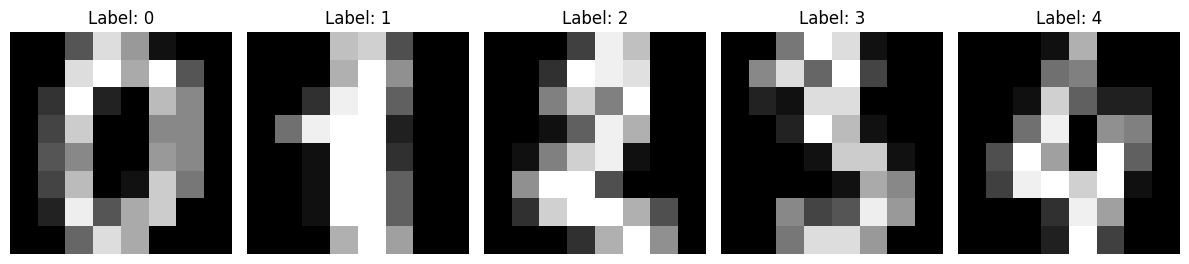

In [9]:
from sklearn import datasets

digits = datasets.load_digits()

fig, ax = plt.subplots(1, 5, figsize=(12, 8))
ax = ax.ravel()

for i in range(5):
    ax[i].imshow(digits.images[i], cmap='gray')
    ax[i].set_title(f'Label: {digits.target[i]}')
    ax[i].axis('off')
    
plt.tight_layout()
plt.show()

In [121]:
def preprocessing(): 
    
    digits = datasets.load_digits()
    scaler = MinMaxScaler()
    X = scaler.fit_transform(digits.data)
    y = digits.target
    
    encoder = OneHotEncoder(sparse_output=False)
    y_one_hot = encoder.fit_transform(y.reshape(-1, 1))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.2, random_state = 42)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, X, y

X_train, X_val, X_test, y_train, y_val, y_test, X, y = preprocessing()


In [179]:
INPUT_DIM = X.shape[1]
OUTPUT_DIM = len(np.unique(y))
HIDDEN_DIM = 128
LOSS_FN = 'cross_entropy'
LEARNING_RATE = 0.1
EPOCHS = 10000
BATCH_SIZE = 32
INIT_METHOD = 'xavier'
DROPOUT_RATE = 0.2
CLIP_TYPE = 'norm'
GRAD_CLIPPING = 1
EARLY_STOPPING = False
PATIENCE = 100

In [195]:
nn = NeuralNetwork([INPUT_DIM, 64, 64, OUTPUT_DIM], LOSS_FN, DROPOUT_RATE, CLIP_TYPE, GRAD_CLIPPING, INIT_METHOD)

trainer = Trainer(nn, LOSS_FN, EPOCHS, LEARNING_RATE, EARLY_STOPPING, PATIENCE)
trainer.train(X_train, y_train, X_val, y_val)


2024-04-09 15:05:20,987 - __main__ - INFO - Epoch 0: loss = 0.07197, val_loss = 0.08110, Train Accuracy: 0.10357
2024-04-09 15:05:22,187 - __main__ - INFO - Epoch 200: loss = 0.22949, val_loss = 0.23120, Train Accuracy: 0.11749
2024-04-09 15:05:23,395 - __main__ - INFO - Epoch 400: loss = 0.22867, val_loss = 0.22987, Train Accuracy: 0.12881
2024-04-09 15:05:24,589 - __main__ - INFO - Epoch 600: loss = 0.22627, val_loss = 0.22671, Train Accuracy: 0.16188
2024-04-09 15:05:25,801 - __main__ - INFO - Epoch 800: loss = 0.22203, val_loss = 0.22426, Train Accuracy: 0.19843
2024-04-09 15:05:26,994 - __main__ - INFO - Epoch 1000: loss = 0.21431, val_loss = 0.21559, Train Accuracy: 0.26458
2024-04-09 15:05:28,179 - __main__ - INFO - Epoch 1200: loss = 0.19615, val_loss = 0.19683, Train Accuracy: 0.36815
2024-04-09 15:05:29,439 - __main__ - INFO - Epoch 1400: loss = 0.17561, val_loss = 0.17894, Train Accuracy: 0.46388
2024-04-09 15:05:30,597 - __main__ - INFO - Epoch 1600: loss = 0.15263, val_los

In [196]:
# Test Set 
y_test_label = np.argmax(y_test, axis=1)
y_pred_label = np.argmax(nn.forward(X_test), axis=1)
test_accuracy = np.mean(y_test_label == y_pred_label)
logger.info(f'Test Accuracy: {test_accuracy:.5f}')

2024-04-09 15:06:28,020 - __main__ - INFO - Test Accuracy: 0.92222


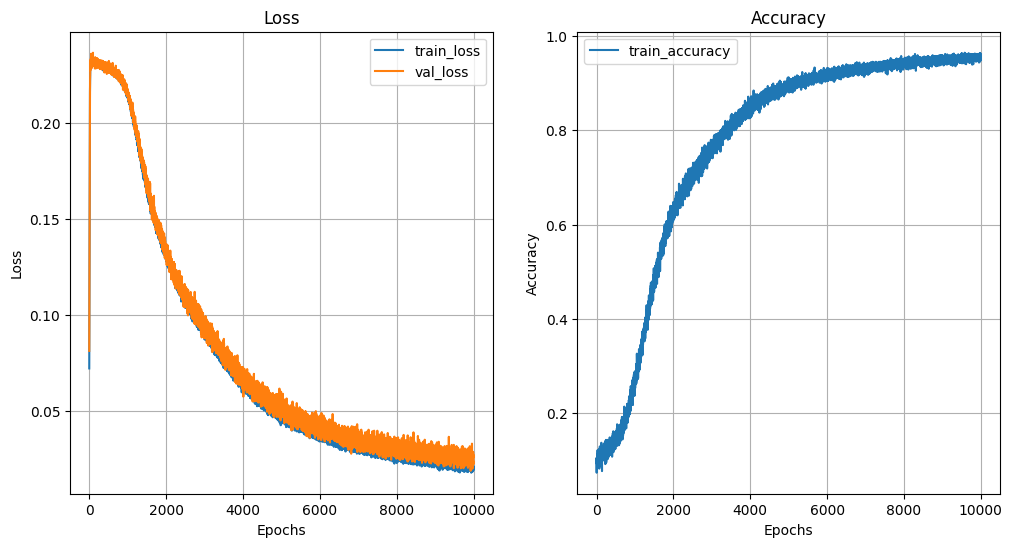

In [197]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(trainer.train_loss, label='train_loss')
plt.plot(trainer.val_loss, label='val_loss')
plt.legend()
plt.title('Loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(trainer.train_accuracy, label='train_accuracy')
plt.legend()
plt.title('Accuracy')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

